In [1]:
from analytics_utils.db_utils import get_db_client, SupportedDBs
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from hs_tree_blenders_creation.batch_runners.data_sets import get_account_test_set
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, auc, roc_curve, f1_score

In [2]:
environment = 'production'
account_id = None
db_type = SupportedDBs.BIGQUERY

db_client = get_db_client(environment, account_id, db_type)

In [3]:
sql = """
SELECT  * FROM `hs-brain.ongoing_measurements.fetch_results` WHERE
TIMESTAMP_TRUNC(timestamp, DAY) > TIMESTAMP("2024-01-20")  
-- AND account_id =  'utah' 
-- AND run_identifier IN ('DEV-20657_DEV-20251-20231112_181713', 'DEV-20657_DEV-20251-20231113_060650') 
AND run_identifier = 'master-20240130_150008'
"""

job_result = db_client.execute(sql)

df = job_result['query_reults'].to_dataframe()
df.shape

(109639, 33)

In [6]:
NEGATIVE = 'random_out_category'

In [7]:
xdf = df[df['evaluation_group'].isin({'offer', NEGATIVE})]
xdf['is_positive'] = xdf['evaluation_group'] == 'offer'
xdf['is_positive'].mean(), xdf.shape

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_70047/2290488944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdf['is_positive'] = xdf['evaluation_group'] == 'offer'


(0.49956662561014553, (43842, 34))

In [35]:
xdf['is_positive'].mean()

0.49956662561014553

In [8]:
def roc(x):
    try:
        return roc_auc_score(x['is_positive'], x['order'])
    except:
        return None

In [40]:
counts = xdf.groupby('account_id')['prediction'].count()
rocs = xdf[xdf['prediction'] == 1].groupby('account_id').apply(roc)
pr = xdf.groupby('account_id').apply(lambda x: precision_score(x['is_positive'], x['prediction']))
re = xdf.groupby('account_id').apply(lambda x: recall_score(x['is_positive'], x['prediction']))
f1 = xdf.groupby('account_id').apply(lambda x: f1_score(x['is_positive'], x['prediction']))

In [21]:
xdf[xdf['prediction'] == 1].groupby('req_id').apply(roc).mean()

0.8195969964832239

In [10]:
print('roc_auc_score:', roc_auc_score(xdf[xdf['prediction'] == 1]['is_positive'], xdf[xdf['prediction'] == 1]['order']))
print('precision_score:', precision_score(xdf['is_positive'], xdf['prediction']))
print('recall_score:', recall_score(xdf['is_positive'], xdf['prediction']))
print('f1_score:', f1_score(xdf['is_positive'], xdf['prediction']))

roc_auc_score: 0.5664736887330489
precision_score: 0.8263665594855305
recall_score: 0.3637567345447904
f1_score: 0.5051516976825287


In [41]:
pd.DataFrame({
    'count': counts, 'roc': rocs,
    'precision': pr, 'recall': re, 'f1': f1
}).sort_values('roc')

,count,roc,precision,recall,f1
account_id,,,,,
hawaii,104,0.365385,0.866667,0.250000,0.388060
exeter,234,0.387255,0.962264,0.435897,0.600000
brooklyn,313,0.421875,0.909091,0.256410,0.400000
colorado,373,0.457792,0.974684,0.413978,0.581132
seattle,2126,0.506679,0.965157,0.260583,0.410370
oxford,984,0.513871,0.756098,0.315041,0.444763
antalya,642,0.525806,0.756098,0.386293,0.511340
indiana,1854,0.531729,0.874055,0.377174,0.526955
sofia,1430,0.535948,0.721414,0.485315,0.580268


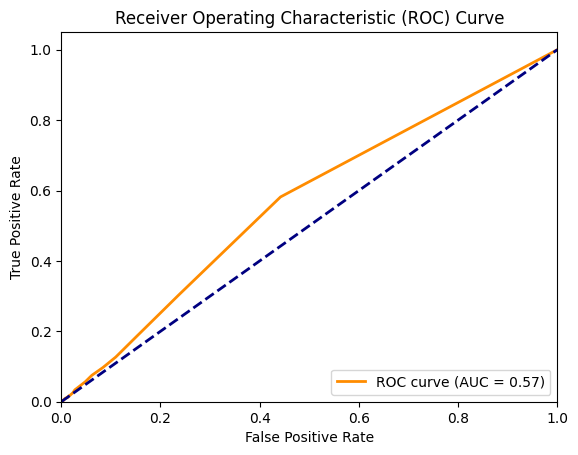

In [12]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(xdf[xdf['prediction'] == 1]['is_positive'], xdf[xdf['prediction'] == 1]['order'])

# Calculate AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Splotlight

In [13]:
sql = """
SELECT  * FROM `hs-brain.ongoing_measurements.grading_results` WHERE
TIMESTAMP_TRUNC(timestamp, DAY) > TIMESTAMP("2023-11-20")  
-- AND account_id =  'jaipur' 
-- AND run_identifier = 'xxxxx'
AND run_tag = 'quarterly'
"""

job_result = db_client.execute(sql)

sdf = job_result['query_reults'].to_dataframe()
sdf.shape

(2767813, 44)

In [23]:
sdf['account_id'].value_counts().count()

14

In [14]:
sdf['is_positive'] = sdf['max_status']  > 0
sdf['is_positive'].value_counts()

False    2388512
True      379301
Name: is_positive, dtype: int64

In [30]:
sdf['raw_explainable_bucketed_score'].describe()

count    2.767813e+06
mean     3.006041e+00
std      1.594915e+00
min      1.000000e+00
25%      1.273511e+00
50%      2.887996e+00
75%      4.843210e+00
max      4.999000e+00
Name: raw_explainable_bucketed_score, dtype: float64

In [29]:
sdf.columns

Index(['account_id', 'timestamp', 'branch', 'run_tag', 'model_name', 'req_id',
       'industry', 'job_education', 'country', 'req_written_languages_top',
       'req_written_languages_num', 'top_category', 'sub_category',
       'min_years_of_relevant_experience', 'application_id', 'is_rehire',
       'is_internal', 'resume_written_languages_top',
       'resume_written_languages_num', 'grading_type', 'raw_predicted_proba',
       'final_predicted_proba', 'raw_explainable_bucketed_score',
       'final_score', 'final_round_score', 'letter_grade',
       'years_of_relevant_experience_insight', 'total_years_of_experience',
       'maximal_industry_match', 'max_status', 'is_forwarded_candidate',
       'meets_qualifications', 'qualification_fail_education',
       'qualification_fail_visa', 'qualification_fail_languages',
       'qualification_fail_skills', 'qualification_fail_certifications',
       'qualification_fail_security_clearance',
       'qualification_fail_years_relevant_exper

In [15]:
sdf['prediction'] = sdf['final_score'] > 3
sdf['prediction'].mean()

0.5333445575983637

In [33]:
sdf['prediction_before_downgrade'] = sdf['raw_explainable_bucketed_score'] > 3
sdf['prediction_before_downgrade'].mean()

0.48590529779287833

In [25]:
def sroc(x):
    try:
        return roc_auc_score(x['is_positive'], x['raw_predicted_proba'])
    except:
        return None

In [26]:
sdf.groupby('req_id').apply(sroc).mean()

0.7172633423121457

In [31]:
sdf['is_positive'].mean()

0.13703996621159018

In [27]:
print('roc_auc_score:', roc_auc_score(sdf['is_positive'], sdf['raw_predicted_proba']))
print('precision_score:', precision_score(sdf['is_positive'], sdf['prediction']))
print('recall_score:', recall_score(sdf['is_positive'], sdf['prediction']))
print('f1_score:', f1_score(sdf['is_positive'], sdf['prediction']))

roc_auc_score: 0.7249038299811243
precision_score: 0.17256289467944003
recall_score: 0.6715959093174023
f1_score: 0.27457519513618706


In [34]:
print('precision_score before downgrade:', precision_score(sdf['is_positive'], sdf['prediction_before_downgrade']))
print('recall_score before downgrade:', recall_score(sdf['is_positive'], sdf['prediction_before_downgrade']))
print('f1_score before downgrade:', f1_score(sdf['is_positive'], sdf['prediction_before_downgrade']))

precision_score before downgrade: 0.20371181393342974
recall_score before downgrade: 0.7223049767862463
f1_score before downgrade: 0.31779565664228426


In [36]:
counts = sdf.groupby('account_id')['raw_predicted_proba'].count()
rocs = sdf.groupby('account_id').apply(sroc)
pr = sdf.groupby('account_id').apply(lambda x: precision_score(x['is_positive'], x['prediction']))
re = sdf.groupby('account_id').apply(lambda x: recall_score(x['is_positive'], x['prediction']))
f1 = sdf.groupby('account_id').apply(lambda x: f1_score(x['is_positive'], x['prediction']))

/Users/dima/.virtualenvs/hs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
pd.DataFrame({
    'count': counts, 'roc': rocs,
    'precision': pr, 'recall': re, 'f1': f1
}).sort_values('roc')

,count,roc,precision,recall,f1
account_id,,,,,
izmir,4404,0.490204,0.293135,0.226361,0.255457
zagreb,23938,0.622454,0.235851,0.755377,0.359466
amman,21095,0.660466,0.075457,0.577865,0.133484
donegal,5054,0.667427,0.756692,0.387805,0.512800
cancun,243810,0.685877,0.182071,0.686685,0.287827
alabama,315549,0.697410,0.329680,0.767711,0.461274
oxford,164516,0.710558,0.127589,0.854828,0.222038
seattle,38345,0.713799,0.167419,0.861407,0.280350
antwerp,72074,0.720960,0.124252,0.649599,0.208603


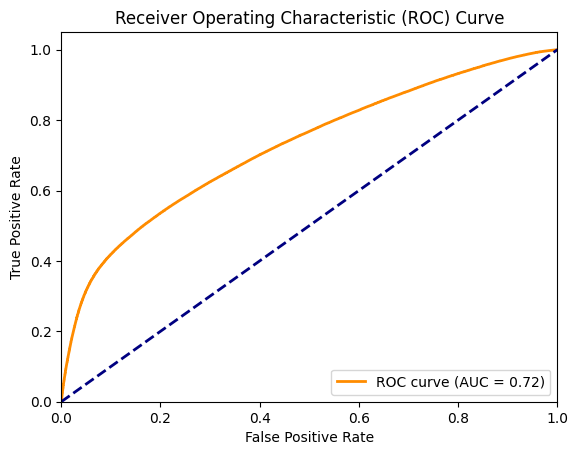

In [38]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(sdf['is_positive'], sdf['raw_predicted_proba'])

# Calculate AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()